In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -qq /content/drive/MyDrive/termwork/visualization.zip

In [ ]:
!unzip -qq /content/drive/MyDrive/termwork/PATH-DT-MSU.WSS1_psi.zip

In [ ]:
!unzip -qq /content/drive/MyDrive/termwork/test_01.psi.zip

In [ ]:
!unzip -qq /content/drive/MyDrive/termwork/test_02.psi.zip

In [ ]:
!unzip -qq /content/drive/MyDrive/termwork/test_03.psi.zip

In [ ]:
!unzip -qq /content/drive/MyDrive/termwork/test_04.psi.zip

In [ ]:
!unzip -qq /content/drive/MyDrive/termwork/test_05.psi.zip

In [ ]:
from pathlib import Path

from PIL import Image
!pip install visualization/psimage-0.1.0-py3-none-any.whl

from psimage.image import PSImage
from skimage import io
import matplotlib.pyplot as plt
import math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode as IM

from tqdm import tqdm

import json

from PIL import Image, ImageDraw

import sys
from pathlib import Path
import numpy as np
import math
import matplotlib.pyplot as plt

from skimage import measure


In [ ]:
def resize(img, target_shape=(512, 512)):
    assert target_shape[0] == target_shape[1]


    img = transforms.Resize(target_shape[0])(img)
    resize_transform = transforms.Compose([
        transforms.CenterCrop(target_shape[0]),
    ])

    return resize_transform(img)

class Classifier:
    def __init__(self, path):
        self.path = path
        psimage = PSImage(self.path)
        self.layers = psimage.layout.layers
        self.tile_s = psimage.layout.tile_s
        numbers = list(range(len(self.layers)))

        layers = [1 << i for i in numbers]
        self.layerTOnumber = dict(zip(numbers, self.layers))

        self.pyramid = []
        for layer in self.layers:
            height_pixels, width_pixels = psimage.layer_size(layer)
            height, width = math.ceil(height_pixels / self.tile_s), math.ceil(width_pixels / self.tile_s)
            tiles = np.full((height, width), -1)
            self.pyramid.append(tiles)

        self.shapes = []
        for tiles in self.pyramid:
            self.shapes.append(tiles.shape)

        self.zero_padding()
        psimage.close()



    def make_classification(self, classifier, batch_size=8):
        classifier.eval()
        with torch.no_grad():
            t_dict = {
                "forward_input": transforms.Compose([
                    transforms.PILToTensor(),
                    transforms.Lambda(lambda x: x.float().to(DEVICE)/255.0),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                std=[0.229, 0.224, 0.225])
                ]),
                "backward_input": transforms.Compose([
                    transforms.Normalize(mean=[0.0, 0.0, 0.0],
                                                std=[1./0.229, 1./0.224, 1./0.225]),
                    transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                                                std=[1.0, 1.0, 1.0]),
                    transforms.Lambda(lambda x: x.permute(1, 2, 0).cpu().numpy())
                ]),
            }

            LAYER = 0
            psimage = PSImage(self.path)
            i = 0
            batch = torch.zeros((batch_size, 3, 512, 512), device='cuda')
            preds = []
            y_x = [(y, x) for y in range(self.shapes[LAYER][0]) for x in range(self.shapes[LAYER][1])]
            for y, x in tqdm(y_x, total=len(y_x)):
                if i == batch_size:
                    pred = classifier(batch)
                    preds.extend(pred.argmax(dim=1).cpu().detach().numpy())
                    batch = torch.zeros((batch_size, 3, 512, 512), device='cuda')
                    i = 0

                image = psimage.get_tile(self.layerTOnumber[0], y, x)
                new_im = resize(Image.fromarray(image), (512, 512))
                trans_im = t_dict['forward_input'](new_im)
                batch[i, ...] = trans_im
                i += 1
            if i != 0:
                pred = classifier(batch[0:i,...])
                preds.extend(pred.argmax(dim=1).cpu().detach().numpy())
            self.pyramid[LAYER][0:self.shapes[LAYER][0], 0:self.shapes[LAYER][1]] = np.array(preds).reshape((self.shapes[LAYER][0], self.shapes[LAYER][1]))

            psimage.close()

    def zero_padding(self):
        for layer in range(0, len(self.layers) - 1):
            tiles = self.pyramid[layer]
            height, width = self.shapes[layer]
            new_tiles = np.zeros((height if height % 2 == 0 else height + 1, width if width % 2 == 0 else width + 1))
            new_tiles[:height, :width] = tiles
            self.pyramid[layer] = new_tiles.astype(int)

    def propagate_prediction(self):
        window_size = 2
        for layer in range(1, len(self.layers)): #начало с первого слоя
            for y in range(self.shapes[layer][0]):
                for x in range(self.shapes[layer][1]):
                    y0, x0 = y * window_size, x * window_size
                    y0, x1 = y * window_size, x * window_size + 1
                    y1, x0 = y * window_size + 1, x * window_size
                    y1, x1 = y * window_size + 1, x * window_size + 1
                    self.pyramid[layer][y][x] = self.pyramid[layer - 1][y0][x0] | self.pyramid[layer - 1][y0][x1] | self.pyramid[layer - 1][y1][x0] | self.pyramid[layer - 1][y1][x1]

    def make_mask(self, layer, shape):
        psim = PSImage(self.path)

        mask = np.zeros(shape)

        size_y, size_x = shape[0] // self.shapes[layer][0], shape[1] // self.shapes[layer][1]

        scip_y = 0
        size_y, size_x, last_y, last_x = self.get_size(shape, self.shapes[layer])

        for y in range(self.shapes[layer][0]):
            scip_x = 0
            scip = 0
            for x in range(self.shapes[layer][1]):
                final_size_y = size_y if y < self.shapes[layer][0] - 1 else last_y
                final_size_x = size_x if x < self.shapes[layer][1] - 1 else last_x
                mask_part = np.full((final_size_y,final_size_x,3), self.pyramid[layer][y][x])

                mask[scip_y:scip_y + mask_part.shape[0], scip_x:scip_x + mask_part.shape[1]] = self.pyramid[layer][y][x]
                scip_x += mask_part.shape[1]
                scip = mask_part.shape[0]
            scip_y += scip

        psim.close()
        return mask

    def get_size(self, shape, layer_shape):
        pows = [1 << i for i in range(15) if ((1 << i) < shape[0]) and ((1 << i) < shape[1])]
        pow1 = min(pows, key=lambda x:abs(x-shape[0]/(layer_shape[0]-1))) if layer_shape[0] != 1 else shape[0]
        pow2 = min(pows, key=lambda x:abs(x-shape[1]/(layer_shape[1]-1))) if layer_shape[1] != 1 else shape[1]
        return pow1, pow2, shape[0] - (layer_shape[0] - 1) * pow1, shape[1] - (layer_shape[1] - 1) * pow2

    def make_json(self):

        psimage = PSImage(self.path)
        codes = []
        for layer, tiles in psimage.layout.tiles_per_layer().items():
            for tile in tiles:
                z, y, x = map(int, tile.code.split('_'))
                if self.pyramid[int(np.log2(z))][y, x] == 0:
                    codes.append(tile.code)

        with open('_'.join(str(self.path).split('/')) + ".json", "w") as file:
            json.dump(codes, file)


    def compute_std_mean(self, z):
        psimage = PSImage(self.path)
        shape = self.shapes[z]
        self.mean_std = np.zeros((shape[0], shape[1], 2))
        for y in tqdm(range(self.shapes[z][0]), total=self.shapes[z][0]):
            for x in range(self.shapes[z][1]):
                tile = Image.fromarray(psimage.get_tile(self.layerTOnumber[z], y, x)).convert('L')
                self.mean_std[y, x] = np.array([np.mean(tile), np.std(tile)])

    # получить бинарную маску на основе соседей для тайла
    def make_maks_for_tile(self, z, y, x, psimage, n=8):
        img = np.array(Image.fromarray(psimage.get_tile(self.layerTOnumber[z], y, x)).convert('L'))

        mask = np.full((512*(self.layerTOnumber[z]) // n, 512*(self.layerTOnumber[z]) // n), 0)

        offsets = np.array([[i + y, j + x] for i in [-1, 0, 1] for j in [-1, 0, 1] if (i != 0 or j != 0) and 0 <= i + y < self.shapes[z][0] - 1
                        and 0 <= j + x < self.shapes[z][1] - 1 and self.pyramid[z][i + y, j + x] == 0])

        mean = np.mean(self.mean_std[offsets[:, 0], offsets[:, 1]][:, 0]) if offsets.size != 0 else None
        std = np.mean(self.mean_std[offsets[:, 0], offsets[:, 1]][:, 1]) if offsets.size != 0 else None
        if(std is not None and mean is not None):
            if img.shape == (512, 512):
                vs = np.array(np.vsplit(img, 512//n))
                ds = np.array(np.dsplit(vs, 512//n))
                rds = ds.reshape((-1,n,n), order='F')

                means = np.mean(rds, axis=(1, 2))[..., None]

                means = means*np.ones(((512//n) * (512//n),self.layerTOnumber[z]**2))

                means = means.reshape(512//n,512//n,self.layerTOnumber[z],self.layerTOnumber[z])

                conc1 = np.concatenate(means, axis=1)
                conc2 = np.concatenate(conc1, axis=1)

                mask[...] = ~((conc2 >= mean - 3 * std) & (conc2 <= mean + 3 * std))
                mask[mask==1] = 255
            else:
                H, W = img.shape
                i_j = [(i, j) for i in range(0, H, n) for j in range(0, W, n)]
                for i, j in i_j:
                    ind_y = slice(i, i+n) if i+n<H else slice(i, H)
                    ind_x = slice(j, j+n) if j+n < W else slice(j, W)
                    mask[i // n, j // n] = 0 if mean - 3 * std <= np.mean(img[ind_y, ind_x]) <= mean + 3 * std else 255
        else:
            mask[...] = 255 if self.pyramid[z][y][x] == 1 else 0
        return mask

    #получить бинарную маску для всего изиображения
    def make_mask(self, z, n=8):
        psim = PSImage(self.path)

        shape = self.shapes[z]
        size_y, size_x = 512*(self.layerTOnumber[z]) // n, 512*(self.layerTOnumber[z]) // n

        mask = np.zeros((shape[0] * size_y, shape[1] * size_x))

        scip_y = -size_y

        y_x = [(y, x) for y in range(self.shapes[z][0]) for x in range(self.shapes[z][1])]
        for y, x in tqdm(y_x, total=len(y_x)):
            if x == 0:
                scip_x = 0
                scip_y += size_y
                #scip = 0
            #for x in range(self.shapes[z][1]):
            mask[scip_y:scip_y + size_y, scip_x:scip_x + size_x] = self.make_maks_for_tile(z, y, x, psim, n)
            scip_x += size_x
            #scip_y += size_y

        psim.close()
        return mask

    #обрезать дополненные нули
    def cut_mask(self, z, mask, N=8):
        with PSImage(p) as psim:
            print(psim.layer_size(self.layerTOnumber[0]))
            hw = np.ceil(np.array(psim.layer_size(self.layerTOnumber[0])) / N)
            #print(hw)
            rest = -np.ceil(hw % (512*(self.layerTOnumber[z])/ N)) + (512*(self.layerTOnumber[z]) / N)
            #print(rest)
            mask_cut = mask[0:int(mask.shape[0] - rest[0]), 0:int(mask.shape[1] - rest[1])].copy()
            return mask_cut

    # нарисовать тайлы на изображении
    def visualize_tiles(self, image, z, N=8):
        hw = np.ceil(np.array(psim.layer_size(self.layerTOnumber[z])) / N)

        image_pil = Image.fromarray(image)
        draw = ImageDraw.Draw(image_pil)
        draw.line([(0, 0),(image.shape[1], 0)], fill=0, width=5)
        y0 = 512 // N * 2**z
        while y0 < image.shape[0]:
            draw.line([(0, y0),(image.shape[1], y0)], fill=0, width=3)
            y0 += 512 // N * 2**z
        draw.line([(0, image.shape[0]),(image.shape[1], image.shape[0])], fill=0, width=5)

        draw.line([(0, 0),(0, image.shape[0])], fill=0, width=5)
        x0 = 512 // N * 2**z
        while x0 < image.shape[1]:
            draw.line([(x0, 0),(x0, image.shape[0])], fill=0, width=3)
            x0 += 512 // N * 2**z
        draw.line([(image.shape[1], 0),(image.shape[1], image.shape[0])], fill=0, width=5)
        return image_pil


In [ ]:
# нарисовать тайлы на разных уровнях
def visualize_tiles(Cl, p):
    #Cl - классификатор
    #p - Path
    #Cl = Classifier(Path(p))
    with PSImage(p) as psim:
        for layer in range(len(Cl.pyramid))
        psim.export_simple(Path("data/out/export.jpg"), scale=(1 / 16))
        image = io.imread("data/out/export.jpg")
        im = Cl.visualize_tiles(image, layer, N=16)
        im.save(f'visualize_tiles_{layer}.jpg')

In [ ]:
# построить бинарную маску для каждого уровня пирамиды
def visualize_method(Cl):
    with PSImage(Cl.path) as psim:
        psim.export_simple(Path("data/out/export.jpg"), scale=1/8)
        image = io.imread("data/out/export.jpg")
    for z in range(len(Cl.pyramid)):
        Cl.compute_std_mean(z)
        Cl1 = Classifier(Path(p))
        Cl1.pyramid = Cl.pyramid
        Cl1.mean_std = Cl.mean_std
        mask = Cl1.make_mask(z, 8)
        cut_mask = Cl1.cut_mask(z, mask, N=8)
        cut_mask = cut_mask[0:image.shape[0], 0:image.shape[1]]
        image_pil = Image.fromarray(image.astype(np.uint8))
        image_pil = image_pil.convert('RGB')
        mask_pil = Image.fromarray(cut_mask.astype(np.uint8))
        preview = Image.blend(image_pil, mask_pil.convert('RGB'), alpha=0.5)
        preview.save(f'WSS_{z}.jpg')

In [ ]:
def make_classification(Cl, classes=2):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', weights=None)
    model.fc = nn.Linear(512, classes)
    model.load_state_dict(torch.load("visualization/best_model.pth"))
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(DEVICE)

    Cl.make_classification(model, batch_size=200)
    Cl.propagate_prediction()

In [ ]:
def get_unique_list(labels):
    props = measure.regionprops(labels)
    label_area = []
    for prop in props:
        label_area.append((prop.label, prop.area))
        #for label in tqdm(unique, total=len(unique)):
    #    squares.append((labels == label).sum())
    #unique = np.unique(labels)
    #squares = []

    #data = list(zip(unique, squares))

    label_area.sort(key=lambda tup: tup[1])
    print(label_area)
    return np.array(label_area)

In [ ]:
import bisect
def get_new_labels(labels, threshold, data):
    bound = bisect.bisect_right(data, threshold, lo=0, hi=len(data), key=lambda tup: tup[1])
    #new_labels = np.copy(labels)
    #print((labels <= data[bound][0]) * (labels >= data[0][0]))
    #new_labels[(labels <= data[bound][0]) * (labels >= data[0][0])] = 0
    mask = np.isin(labels, data[0:bound, 0])
    labels[mask] = 0
    #for i in tqdm(range(bound), total=bound):
    #    labels[labels == data[i][0]] = 0
        #mask = np.where(mask == data[i][0], 0, mask)
    return data[bound:]

In [ ]:
def make_mask(Cl, z=0):
    #z - уровень пирамиды
    with PSImage(p) as psim:
        psim.export_simple(Path("data/out/export.jpg"), scale=1/8)
        image = io.imread("data/out/export.jpg")
    Cl.compute_std_mean(z)
    mask = Cl.make_mask(z, 8)
    cut_mask = Cl.cut_mask(z, mask, N=8)

    all_labels = measure.label(cut_mask)
    val, counts = np.unique(all_labels, return_counts=True)

    x = get_unique_list(all_labels)

    image_pil = Image.fromarray(image.astype(np.uint8))
    image_pil = image_pil.convert('RGB')
    del image
    image_pil.save(f'/content/drive/MyDrive/termwork/visualization/start_image.jpg')

    thresholds = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000]
    for threshold in tqdm(thresholds):
        end_image = np.array(image_pil)
        x = get_new_labels(all_labels, threshold, x)
        #plt.imshow(all_labels)
        new_labels = all_labels.copy()
        new_labels[new_labels > 0] = 255
        end_image[new_labels != 255] = np.array([255, 255, 255])


        end_image_pil = Image.fromarray(end_image.astype('uint8'), 'RGB')
        mask_pil = Image.fromarray(new_labels.astype(np.uint8))

        del new_labels
        del end_image

        preview = Image.blend(image_pil, mask_pil.convert('RGB'), alpha=0.3)
        end_image_pil.save(f'/content/drive/MyDrive/termwork/visualization/end_image_{threshold}.jpg')
        preview.save(f'/content/drive/MyDrive/termwork/visualization/preview_{threshold}.jpg')
        mask_pil.save(f'/content/drive/MyDrive/termwork/visualization/mask_{threshold}.jpg')

In [ ]:
p = Path("PATH-DT-MSU. WSS1 (psi)/test_01.psi")
Cl = Classifier(Path(p))

In [ ]:
make_classification(Cl)

In [ ]:
visualize_method(Cl)

100%|██████████| 2256/2256 [00:21<00:00, 103.16it/s]


(24492, 23904)


100%|██████████| 576/576 [00:08<00:00, 65.63it/s]


(24492, 23904)


100%|██████████| 144/144 [00:00<00:00, 147.92it/s]


(24492, 23904)


100%|██████████| 36/36 [00:00<00:00, 60.27it/s] 


(24492, 23904)


100%|██████████| 9/9 [00:00<00:00, 274.99it/s]


(24492, 23904)


100%|██████████| 4/4 [00:00<00:00, 74.81it/s]


(24492, 23904)


In [ ]:
make_mask(Cl, 0)

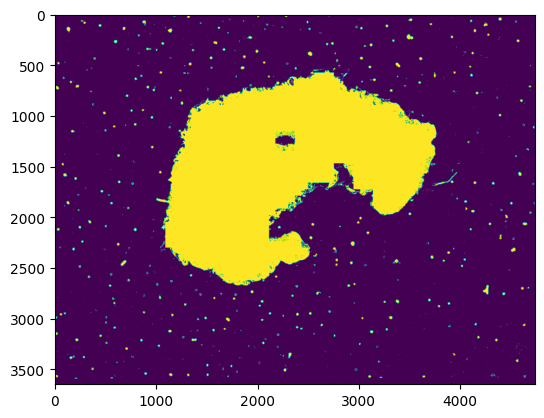

In [ ]:
plt.imshow(mask)

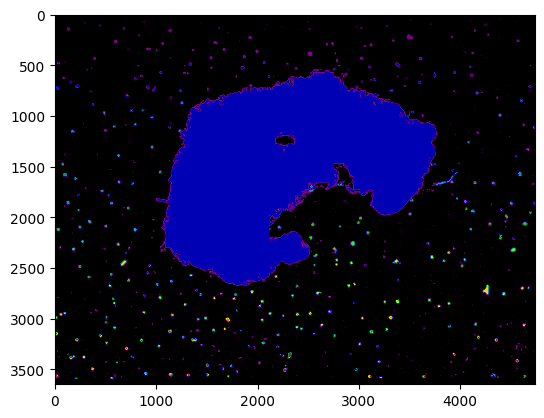

In [ ]:
plt.imshow(all_labels, cmap='nipy_spectral')

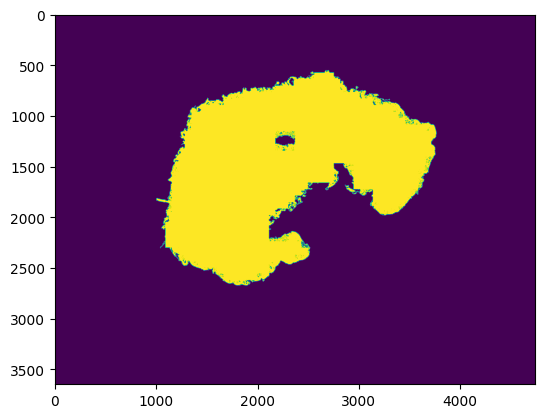

In [ ]:
plt.imshow(new_mask)

In [ ]:
def make_mask(psim, size, stride, classifier):
    classifier.eval()
    with torch.no_grad():
        t_dict = {
            "forward_input": transforms.Compose([
                transforms.PILToTensor(),
                transforms.Lambda(lambda x: x.float().to(DEVICE)/255.0),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])
            ]),
            "backward_input": transforms.Compose([
                transforms.Normalize(mean=[0.0, 0.0, 0.0],
                                            std=[1./0.229, 1./0.224, 1./0.225]),
                transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                                            std=[1.0, 1.0, 1.0]),
                transforms.Lambda(lambda x: x.permute(1, 2, 0).cpu().numpy())
            ]),
        }
        layers = psim.layout.layers
        numbers = list(range(len(layers)))
        layers = [1 << i for i in numbers]
        layerTOnumber = dict(zip(numbers, layers))

        layer = layers[0]
        height_pixels, width_pixels = psim.layer_size(layer)
        height, width = math.ceil(height_pixels / stride), math.ceil(width_pixels / stride)


        window_size = (size // stride)

        xv, yv = np.meshgrid(np.arange(width), np.arange(height))

        coords = np.zeros((3, height, width), dtype=np.uint8)
        mask = np.full((window_size ** 2, height, width), np.nan)
        coords[1, ...] = yv
        coords[2, ...] = xv
        stride_y = 0
        stride_x = 0
        next = 0
        for patch in tqdm(psim.patch_gen_dense(size, stride=stride)):

            if patch.pos_y / stride > stride_y:
                stride_x = 0
                stride_y += 1

            data = patch.data
            patch_height, patch_width, C = data.shape
            size_y, size_x = math.ceil(patch_height / stride), math.ceil(patch_width / stride)
            slic = np.s_[:, stride_y:stride_y + size_y,stride_x:stride_x + size_x]
            cor = coords[slic]
            ravel_cor = np.zeros((3, cor[0].size), dtype=np.uint8)
            ravel_cor[0] = cor[0].ravel()
            ravel_cor[1] = cor[1].ravel()
            ravel_cor[2] = cor[2].ravel()

            stride_x += 1
            new_im = resize(Image.fromarray(data), (512, 512))
            trans_im = t_dict['forward_input'](new_im)
            pred = classifier(torch.unsqueeze(trans_im, 0))
            mask[ravel_cor[0], ravel_cor[1], ravel_cor[2]] = pred.argmax().cpu().detach().numpy()
            cor[0] += 1


        delitel = (~np.isnan(mask)).sum(axis=0)
        mask = np.where(np.isnan(mask), 0, mask)

        return mask.sum(axis=0) / delitel

In [ ]:
def make_heatmap(psim, shape, mask, scale, stride):
    layers = psim.layout.layers
    tile_s = psim.layout.tile_s
    numbers = list(range(len(layers)))
    layers = [1 << i for i in numbers]
    layerTOnumber = dict(zip(numbers, layers))

    heatmap = np.zeros(shape)

    layer = layers[0]
    height_pixels, width_pixels = psim.layer_size(layer)
    height, width = math.ceil(height_pixels / tile_s), math.ceil(width_pixels / tile_s)

    scip_y = 0
    for y in range(mask.shape[0]):
        scip_x = 0
        scip = 0
        for x in range(mask.shape[1]):
            heatmap_part = np.full((int(stride * scale),int(stride * scale),3), mask[y][x])
            heatmap[scip_y:scip_y + heatmap_part.shape[0], scip_x:scip_x + heatmap_part.shape[1]] = mask[y][x]
            scip_x += heatmap_part.shape[1]
            scip = heatmap_part.shape[0]
        scip_y += scip
    return heatmap

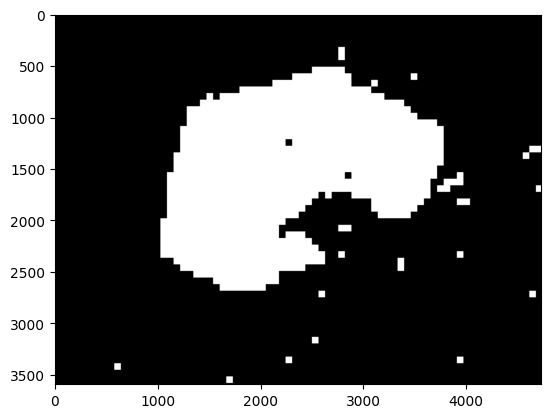

In [ ]:
plt.imshow(mask)

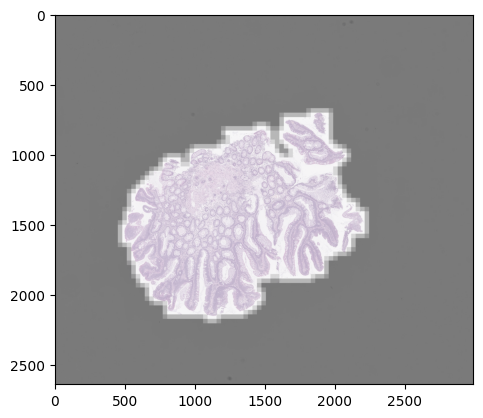

In [ ]:
with PSImage(p) as psim:
    heatmap = make_heatmap(psim, image.shape, mask, 0.0625, 256)
    plt.imshow(image)
    plt.imshow(heatmap, alpha=0.5)
    plt.show()

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', weights=None)
model.fc = nn.Linear(512, 2)
model.load_state_dict(torch.load("visualization/best_model.pth", map_location=torch.device('cpu')))
model.to(DEVICE)
p = Path("test_01.psi")
with PSImage(p) as psim:
    mask = make_mask(psim, 512, 256, model)
    psim.export_simple(Path("data/out/export.jpg"), scale=0.0625)
    image = io.imread("data/out/export.jpg")
    heatmap = make_heatmap(psim, image.shape, mask, 0.0625, 256)
    plt.imshow(image)
    plt.imshow(heatmap, alpha=0.5)
    plt.show()

In [ ]:
save_mask(heatmap, 'heat2.jpg')